In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import emoji
import operator 
import json
from collections import Counter
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import datetime as dt
pd.set_option('display.max_colwidth', -1)


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Loading data sample (~5M):

In [5]:
df = pd.read_csv('/Users/alex/Downloads/sample.csv',
                 sep=',', 
                 lineterminator='\n', 
                 encoding = 'utf8')
dataSize = df.shape
print("Data loaded: {}".format(dataSize))

Data loaded: (4065, 18)


In [8]:
df['ad_screen_ratio'] = df['ad height'] / df['screen width']

In [9]:
df.head()

,ad_id,is_viewd,hour,browser,fold,site_id,site_domain,site_category,user_id,device_vendor,device_type,connection,screen width,ad height,load time (ms),attempt index,avg scroll depth in url,traffic_source,ad_screen_ratio
0,1.164401e+19,0,0,facebook ios,1,85f751fd,c4e18dd6,50e219e0,6e8b51b2,620311f4,mobile,wifi,320,50,2161,0,57,direct,0.156250
1,1.273793e+19,0,0,facebook ios,1,1fbe01fe,f3845767,28905ebd,cafcf3f8,293291c1,mobile,wifi,320,50,1722,0,21,serach,0.156250
2,1.402122e+18,0,0,facebook ios,1,5b08c53b,7687a86e,3e814130,667690,a25f5408,mobile,wifi,300,250,1994,2,67,serach,0.833333
3,1.568338e+18,0,0,facebook ios,1,35584290,880a1c2d,f028772b,a53800a9,8a4875bd,mobile,wifi,320,50,2333,0,57,direct,0.156250
4,1.769218e+19,0,0,facebook ios,1,543a539e,c7ca3108,3e814130,1a625b72,85ee5f3e,mobile,wifi,320,50,2333,0,57,serach,0.156250


In [10]:
categorical = ['browser','site_id','site_domain','site_category','user_id','device_vendor','device_type','connection','traffic_source']
numrical = ['hour','fold','screen width','ad height','load time (ms)','attempt index','avg scroll depth in url','ad_screen_ratio']

# Explore categorigal columns - Distributions 

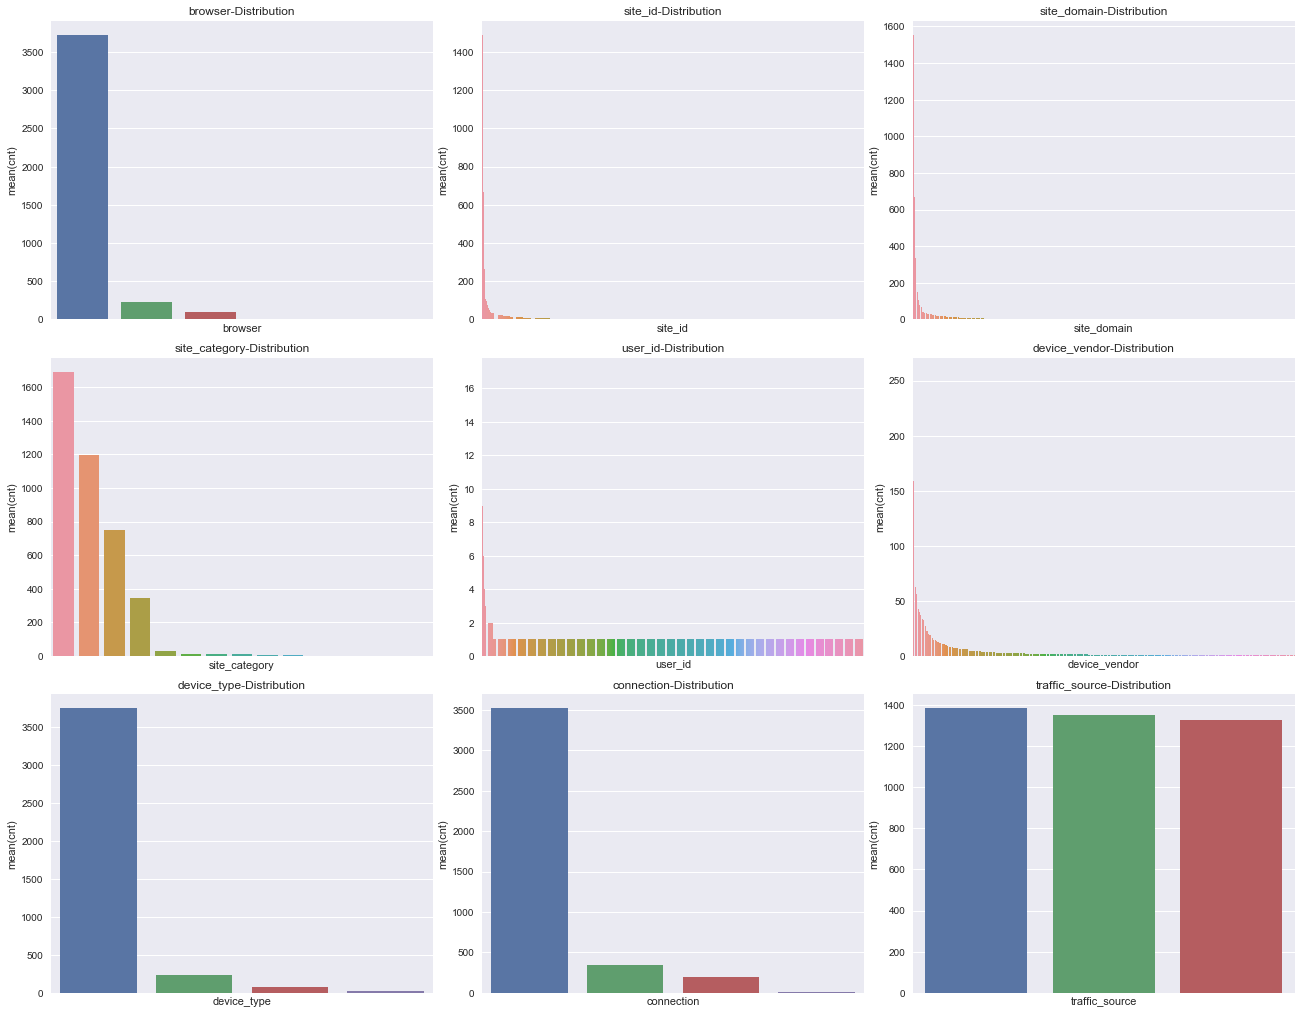

In [11]:
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'ad_id':'count'})\
    .reset_index().rename(columns={'ad_id': 'cnt'}).sort_values(['cnt'],ascending=False)
    plt.subplot(3,3,i)
    sns.barplot(df_grouped[dim],df_grouped['cnt'])
    plt.title('{}-Distribution'.format(dim))
    plt.xticks([])
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

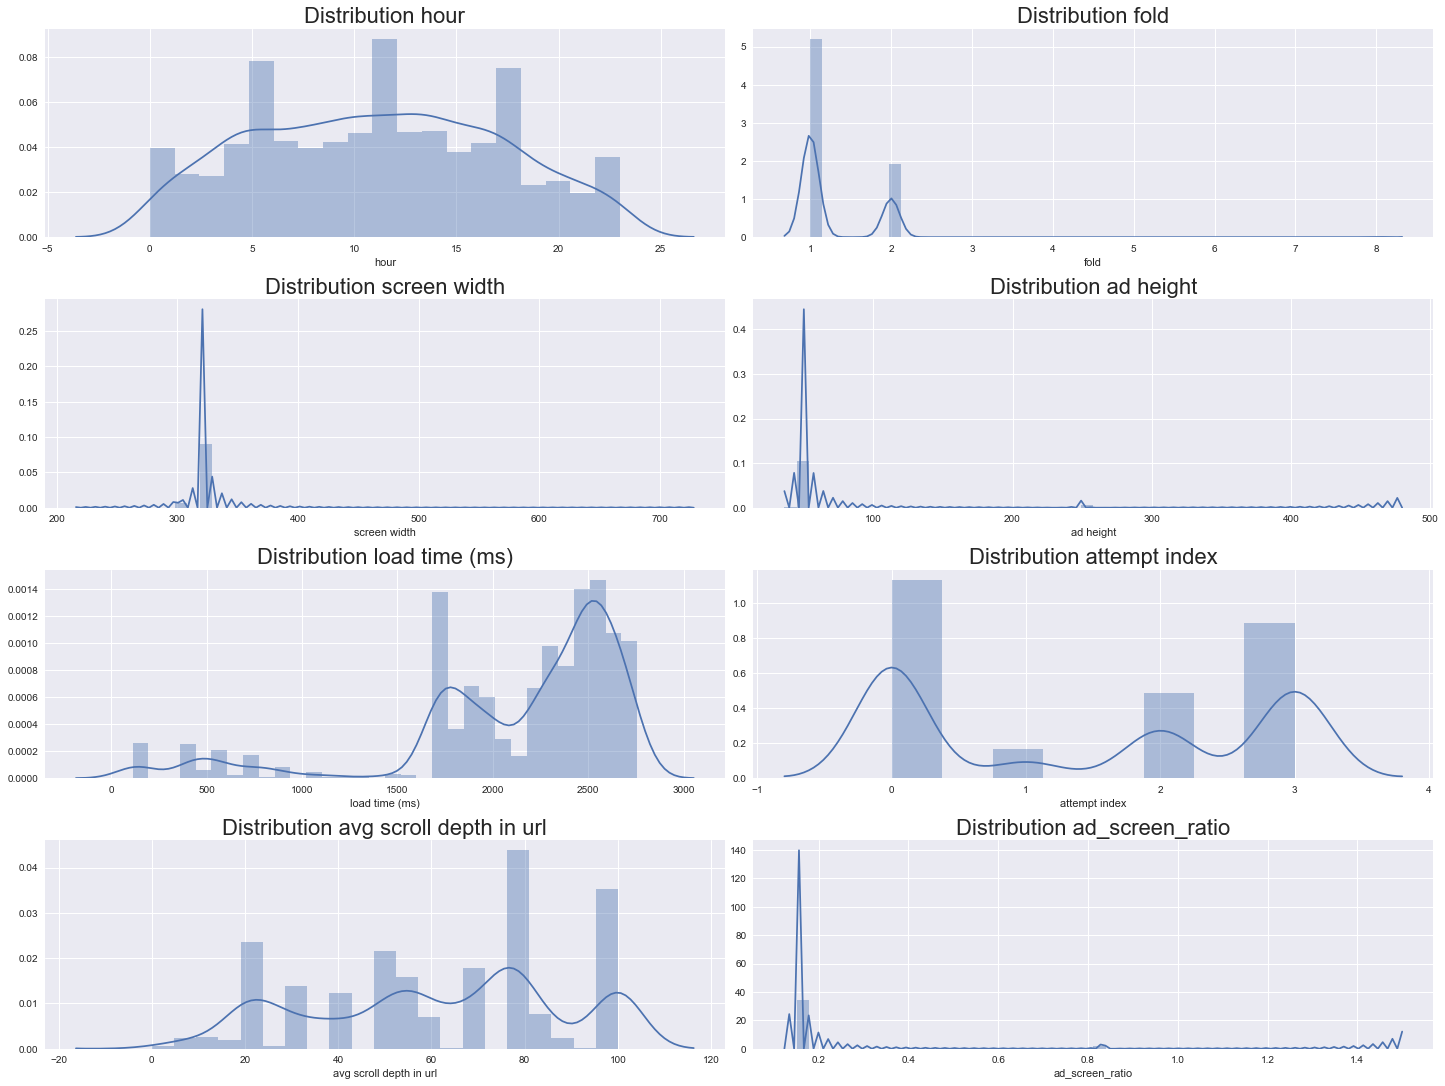

In [58]:
i=1
plt.figure(figsize=(20,15))
for dim in numrical:
    plt.subplot(4,2,i)
    sns.distplot(df[dim])
    plt.title('Distribution '+dim, fontsize=22)
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [64]:
def calculateRate(x,y):
    output = x/y
    return output

ALPHA = 0.05

def calculateError(q, N, alpha):
    from scipy.stats import norm
    z = norm.ppf(1 - alpha / 2)
    sigma = np.sqrt(q * (1 - q))
    error = sigma * z / np.sqrt(N)
    return error

In [153]:
categorical = ['browser','site_id','site_domain','site_category','device_vendor','device_type','connection','traffic_source','attempt index','hour','fold']
numrical = ['screen width','ad height','load time (ms)','avg scroll depth in url']

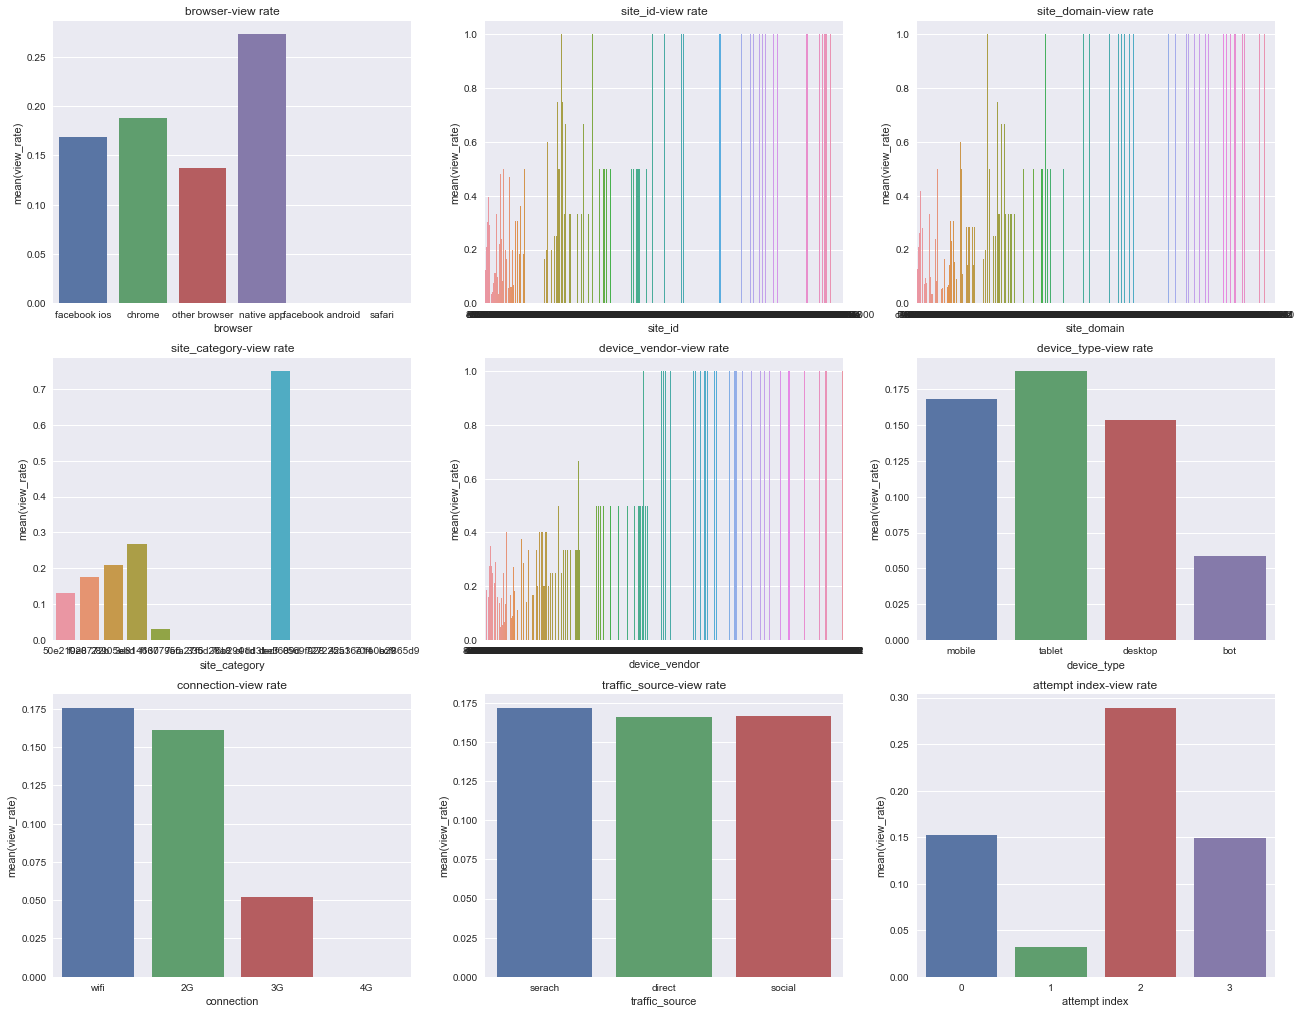

In [66]:
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'ad_id':'count', 'is_viewd':'sum'})\
    .reset_index().rename(columns={'ad_id': 'cnt','is_viewd':'sum'}).sort_values(['cnt'],ascending=False)
    df_grouped['view_rate'] = df_grouped.apply(lambda row: calculateRate(row['sum'],row['cnt']),axis=1)
    plt.subplot(3,3,i)
    sns.barplot(df_grouped[dim],df_grouped['view_rate'])
    plt.title('{}-view rate'.format(dim))
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# removing outliers - because we do not have a lot of data -> we will group into minority groups...

In [82]:
df_filtered = df
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'ad_id':'count'})\
    .reset_index().rename(columns={'ad_id': dim+'_cnt'})
    df_grouped[dim+'_ratio'] = df_grouped[dim+'_cnt']/dataSize[0]
    df_filtered = pd.merge(df_filtered,df_grouped, how = 'left', on = dim)


In [88]:
df_filtered.head()

,ad_id,is_viewd,hour,browser,fold,site_id,site_domain,site_category,user_id,device_vendor,...,device_vendor_cnt,device_vendor_ratio,device_type_cnt,device_type_ratio,connection_cnt,connection_ratio,traffic_source_cnt,traffic_source_ratio,attempt index_cnt,attempt index_ratio
0,1.164401e+19,0,0,facebook ios,1,85f751fd,c4e18dd6,50e219e0,6e8b51b2,minority,...,3,0.000738,3741,0.920295,3520,0.865929,1353,0.332841,1726,0.424600
1,1.273793e+19,0,0,facebook ios,1,1fbe01fe,f3845767,28905ebd,cafcf3f8,293291c1,...,6,0.001476,3741,0.920295,3520,0.865929,1383,0.340221,1726,0.424600
2,1.402122e+18,0,0,facebook ios,1,5b08c53b,7687a86e,3e814130,667690,minority,...,2,0.000492,3741,0.920295,3520,0.865929,1383,0.340221,740,0.182042
3,1.568338e+18,0,0,facebook ios,1,minority,minority,f028772b,a53800a9,8a4875bd,...,258,0.063469,3741,0.920295,3520,0.865929,1353,0.332841,1726,0.424600
4,1.769218e+19,0,0,facebook ios,1,minority,minority,3e814130,1a625b72,minority,...,1,0.000246,3741,0.920295,3520,0.865929,1383,0.340221,1726,0.424600


In [84]:
def is_minority(dim,ratio,threshold):
    if ratio<= threshold:
        return 'minority'
    else:
        return dim

In [91]:
for dim in categorical:
    df_filtered[dim] = df_filtered.apply(lambda row: is_minority(row[dim],row[dim+'_ratio'],0.005),axis=1)

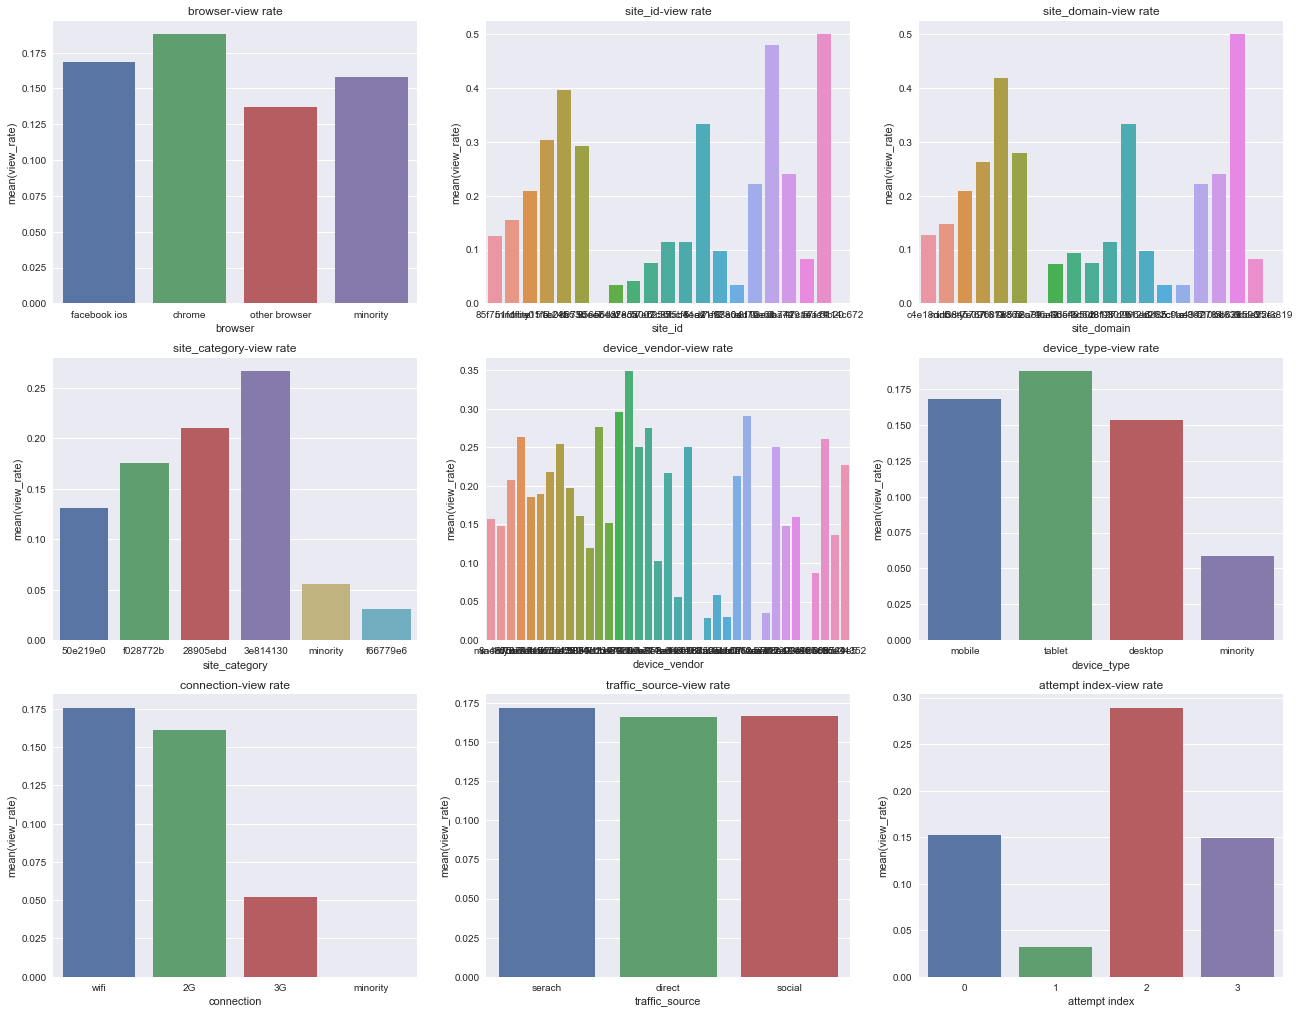

In [92]:
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df_filtered.groupby([dim]).agg({'ad_id':'count', 'is_viewd':'sum'})\
    .reset_index().rename(columns={'ad_id': 'cnt','is_viewd':'sum'}).sort_values(['cnt'],ascending=False)
    df_grouped['view_rate'] = df_grouped.apply(lambda row: calculateRate(row['sum'],row['cnt']),axis=1)
    plt.subplot(3,3,i)
    sns.barplot(df_grouped[dim],df_grouped['view_rate'])
    plt.title('{}-view rate'.format(dim))
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [41]:
from scipy import stats

df_numerical = df[numrical][(np.abs(stats.zscore(df[numrical])) < 3).all(axis=1)]

In [93]:
df_filtered.shape

(4065, 37)

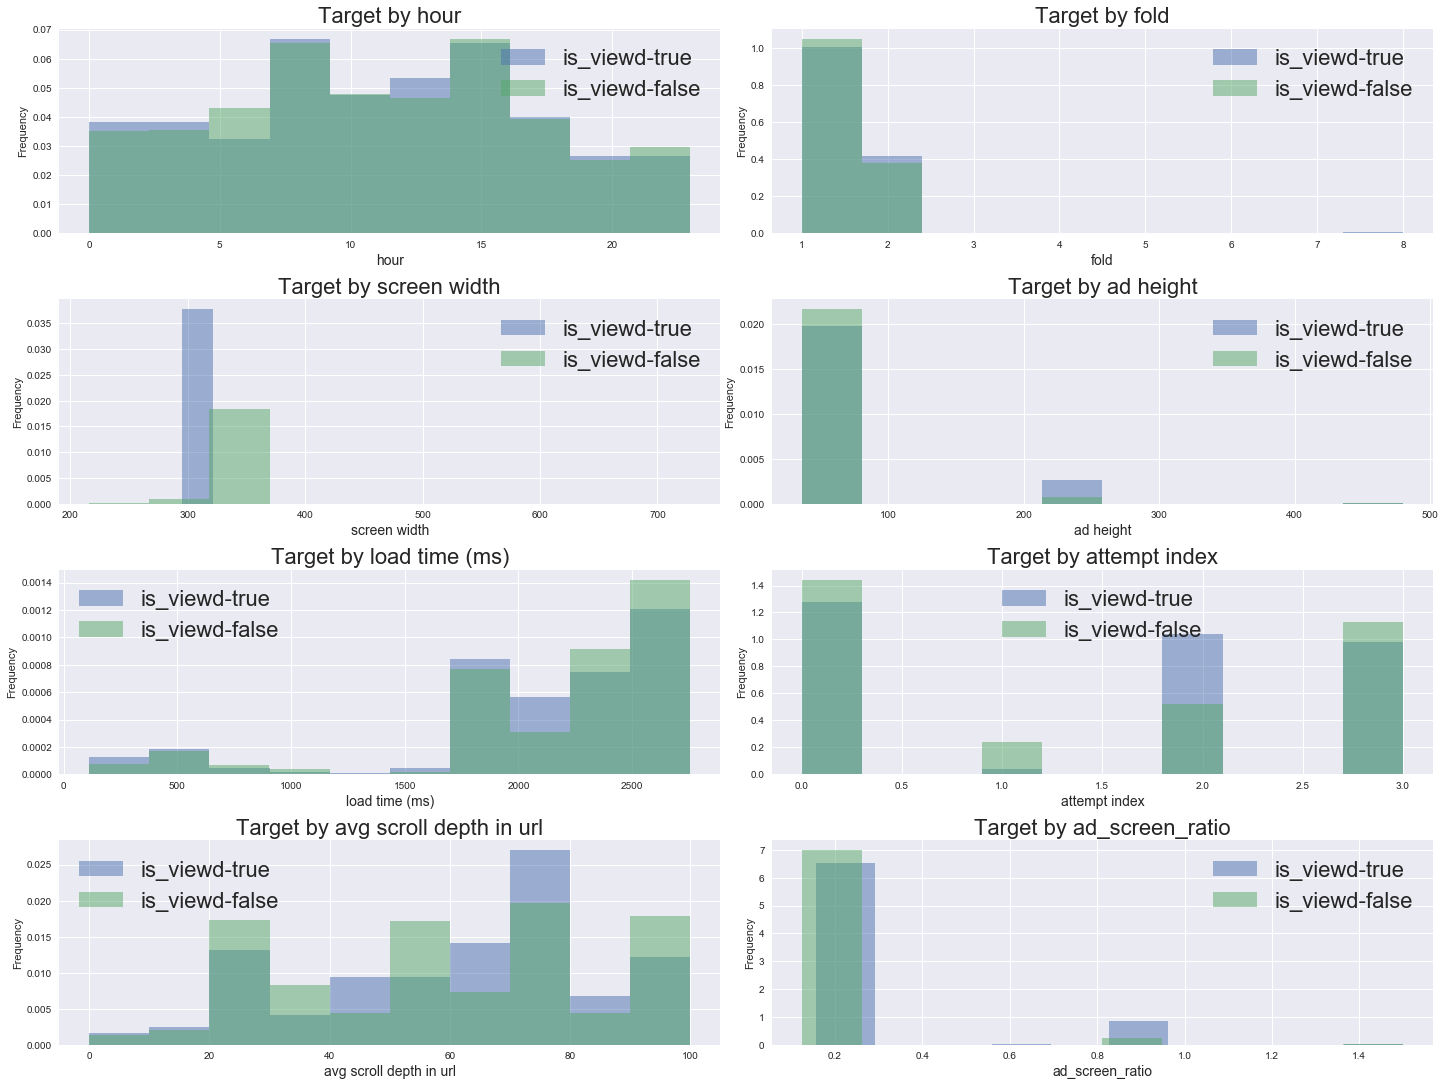

In [18]:
i=1
plt.figure(figsize=(20,15))
for dim in numrical:
    plt.subplot(4,2,i)
    ax = df.query('is_viewd == 1')[dim].plot.hist(label='is_viewd-true', normed=True, alpha=0.5)
    df.query('is_viewd == 0')[dim].plot.hist(label='is_viewd-false', normed=True, alpha=0.5)
    plt.scatter
    plt.legend(fontsize=22)
    ax.set_xlabel(dim, fontsize=14)
    plt.title('Target by '+dim, fontsize=22)
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [95]:
dataset = pd.get_dummies(df_filtered, prefix=categorical, columns=categorical)

In [179]:
cols_of_intreset = ['hour', 'fold', 'screen width', 'ad height', 'load time (ms)', 'avg scroll depth in url', 'browser_chrome', 'browser_facebook ios', 'browser_minority', 'browser_other browser', 'site_category_28905ebd', 'site_category_3e814130', 'site_category_50e219e0', 'site_category_f028772b', 'site_category_f66779e6', 'site_category_minority', 'device_type_desktop', 'device_type_minority', 'device_type_mobile', 'device_type_tablet', 'connection_2G', 'connection_3G', 'connection_minority', 'connection_wifi', 'traffic_source_direct', 'traffic_source_serach', 'traffic_source_social', 'attempt index_0', 'attempt index_1', 'attempt index_2', 'attempt index_3']



# Ploting the correlation matrix:
<p style="font-size:16px"><span style="color:red">
It seems like there are some features that are correlated between themselves - which indicates we should reduce the dimensionality of the feature space. 
</span>

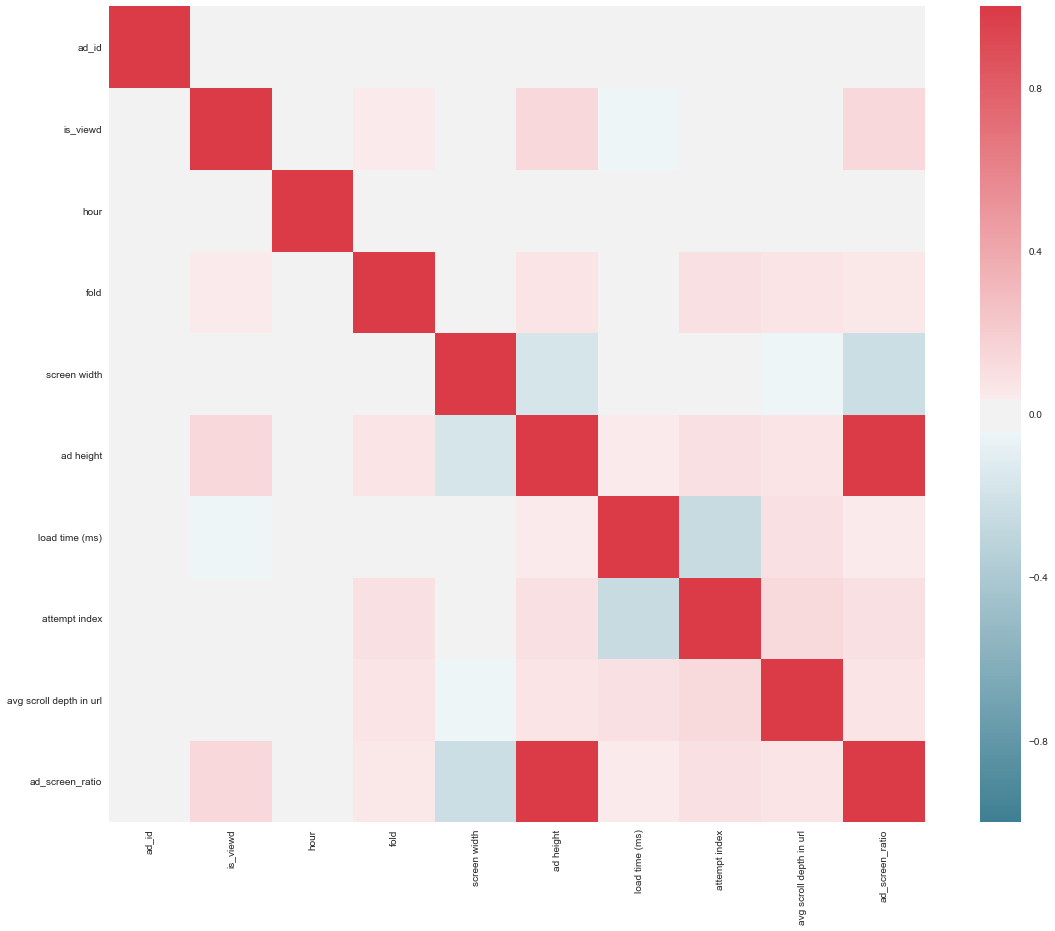

In [120]:
f, ax = plt.subplots(figsize=(20, 15))
corr = df.corr()
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

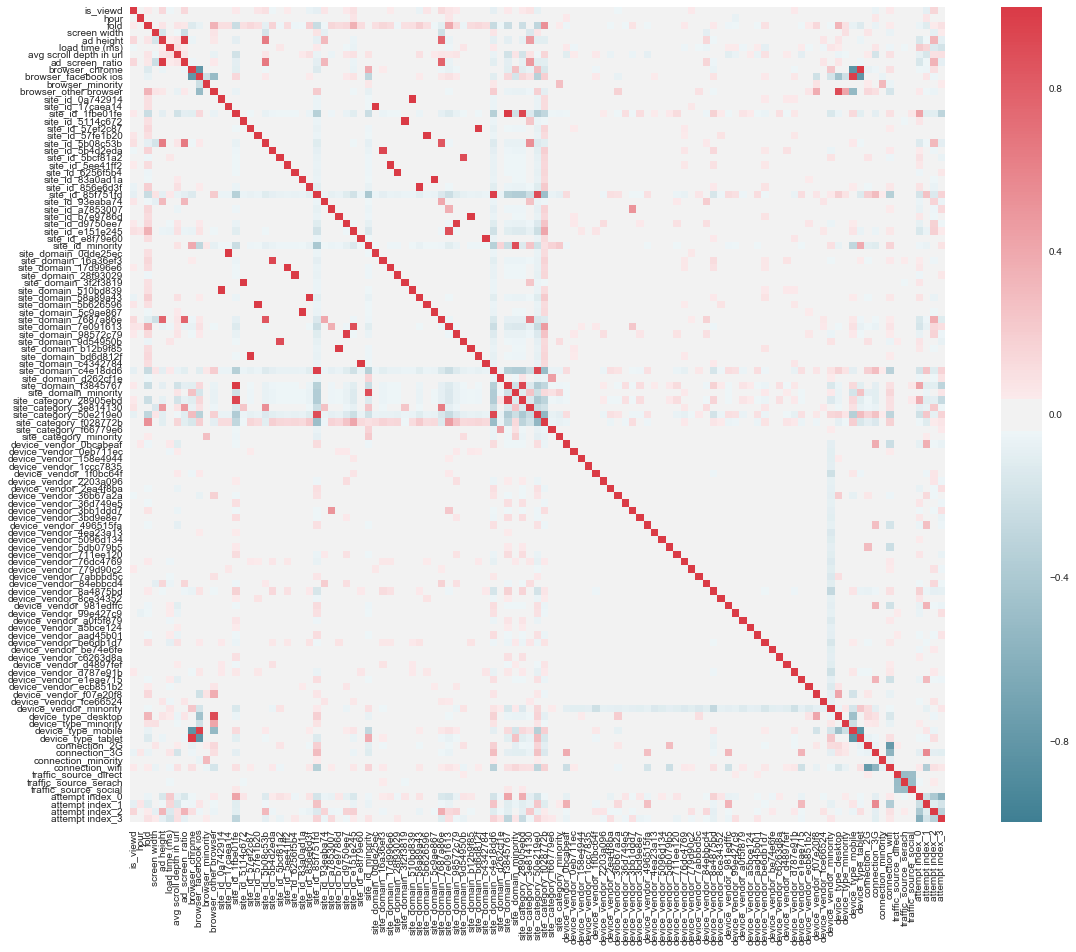

In [169]:
f, ax = plt.subplots(figsize=(20, 15))
corr = dataset_train_test.corr()
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Scaling the features:

In [163]:
from sklearn import preprocessing

def normelize_df(df,numeric_features):
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(df[numeric_features])
    df[numeric_features] = min_max_scaler.transform(df[cols_of_intreset])
    return df


# Model Training:
<p style="font-size:16px"><span style="color:red">
2 models were chosen: Random Forest and Logistic Regression. It is easy to implement, is very interpretable (Feature importance), both can return probabilities (regressors), fast fit, low variance, has decent performance with imbalanced datasets( which is not the case here :) ). 
</span>

In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset[cols_of_intreset], 
                                                    dataset['is_viewd'], 
                                                    test_size=0.3,
                                                    random_state=30)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(dataset[cols_of_intreset], 
                                                                dataset['is_viewd'], 
                                                                test_size=0.3,
                                                                random_state=30)

In [283]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as AUC

logisticReg = LogisticRegression(penalty='l1',C=3)
logisticReg.fit(X_train, y_train)
random_forest = RandomForestClassifier(n_estimators=70, max_depth=15, random_state=1)
logisticReg.fit(X_train, y_train)
random_forest.fit(X_train_rf, y_train_rf)

auc_log = AUC(y_test, logisticReg.predict_proba(X_test)[:, 1])
acc_log = accuracy_score(y_test, logisticReg.predict_proba(X_test)[:, 1].round())
auc_for = AUC(y_test_rf, random_forest.predict_proba(X_test_rf)[:, 1])
acc_for = accuracy_score(y_test_rf, random_forest.predict_proba(X_test_rf)[:, 1].round())

In [276]:
def get_diagram_data(y, p, n_bins):
    n_bins = float(n_bins)  
    mean_predicted_values = np.empty((0,))
    true_fractions = np.zeros((0,))

    for b in range(1, int(n_bins) + 1):
        i = np.logical_and(p <= b / n_bins, p > (b - 1) / n_bins)  # indexes for p in the current bin

        if np.sum(i) == 0 or np.sum(y[i]) == 0:
            continue

        mean_predicted_value = np.mean(p[i])
        true_fraction = float(np.sum(y[i]) / np.sum(i))

        mean_predicted_values = np.hstack((mean_predicted_values, mean_predicted_value))
        true_fractions = np.hstack((true_fractions, true_fraction))

    return (mean_predicted_values, true_fractions)

Logistic Regressions : AUC: 0.607600162394683 | ACC: 0.8188524590163935
Random Forest: AUC: 0.6149124847754984 | ACC: 0.8081967213114755


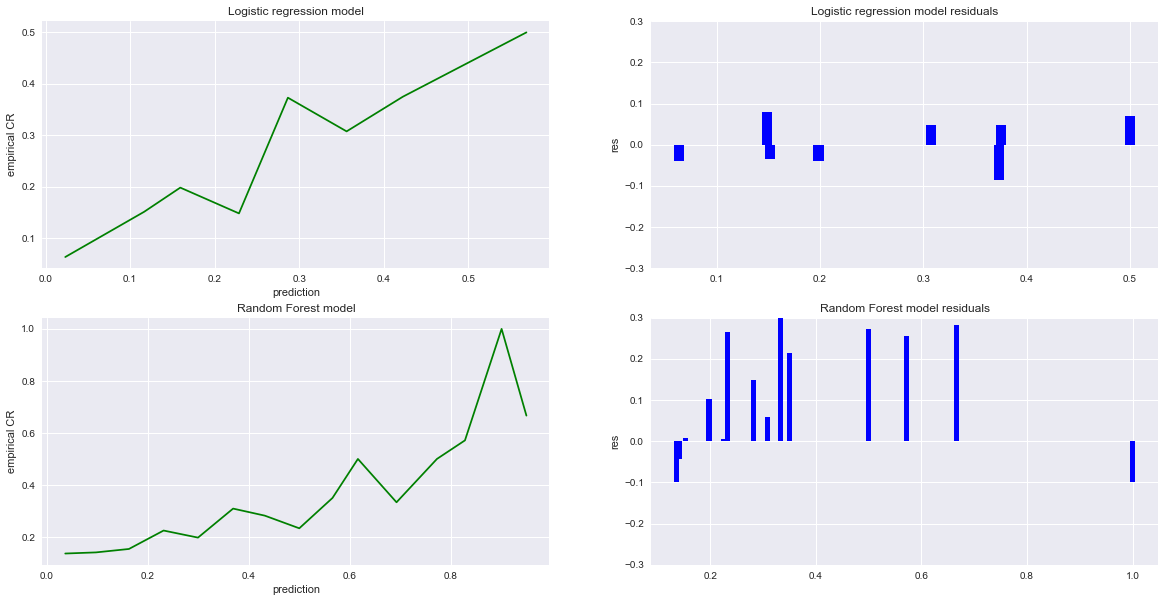

In [284]:
print('Logistic Regressions : AUC: {} | ACC: {}'.format(auc_log,acc_log))
print('Random Forest: AUC: {} | ACC: {}'.format(auc_for,acc_for))

plt.subplots(figsize=(20, 10))
n_bins = 15
meanValues_labels_log, meanValues_P_log = get_diagram_data(y_test, logisticReg.predict_proba(X_test)[:, 1], n_bins)
plt.subplot(2, 2, 1)
plt.plot(meanValues_labels_log, meanValues_P_log, 'green')
plt.xlabel('prediction')
plt.ylabel('empirical CR')
plt.title('Logistic regression model')
plt.subplot(2, 2, 2)
width = 0.01
plt.bar(meanValues_P_log,meanValues_labels_log - meanValues_P_log, width,color='b')
plt.xlabel('')
plt.ylim(-0.3, 0.3)
plt.ylabel('res')
plt.title('Logistic regression model residuals')
meanValues_labels_rf, meanValues_P_rf = get_diagram_data(y_test, random_forest.predict_proba(X_test_rf)[:, 1], n_bins)
plt.subplot(2, 2, 3)
plt.plot(meanValues_labels_rf, meanValues_P_rf, 'green')
plt.xlabel('prediction')
plt.ylabel('empirical CR')
plt.title('Random Forest model')
plt.subplot(2, 2, 4)
width = 0.01
plt.bar(meanValues_P_rf,meanValues_labels_rf - meanValues_P_rf, width,color='b')
plt.xlabel('')
plt.ylim(-0.3, 0.3)
plt.ylabel('res')
plt.title('Random Forest model residuals')

# Evaluating the Models: QQ Plots, AUC, ACC , Calibration ratio, Accuracy, Precision, Recall, P-distribution, confusion-matrix

In [285]:
from sklearn.metrics import confusion_matrix
class_test = logisticReg.predict(X_test)
class_test_rf = random_forest.predict(X_test_rf)
print('Logistic Regression Confusion Matrix')
pd.DataFrame(
    confusion_matrix(y_test, class_test),
    columns=['Predicted view=False', 'Predicted view=True'],
    index=['True view=False', 'True view=True']
)

Logistic Regression Confusion Matrix


,Predicted view=False,Predicted view=True
True view=False,998,3
True view=True,218,1


In [286]:
print('Random Forest Confusion Matrix')
pd.DataFrame(
    confusion_matrix(y_test_rf, class_test_rf),
   columns=['Predicted view=False', 'Predicted view=True'],
    index=['True view=False', 'True view=True']
)

Random Forest Confusion Matrix


,Predicted view=False,Predicted view=True
True view=False,958,43
True view=True,191,28


Logistic Regression Predicted views: 16.21516964712662
Logistic Regression Calibration Ratio: 1.1070386596486883
Random Forest Predicted views: 17.175211157589505
Random Forest Calibration Ratio: 1.0451586013950642


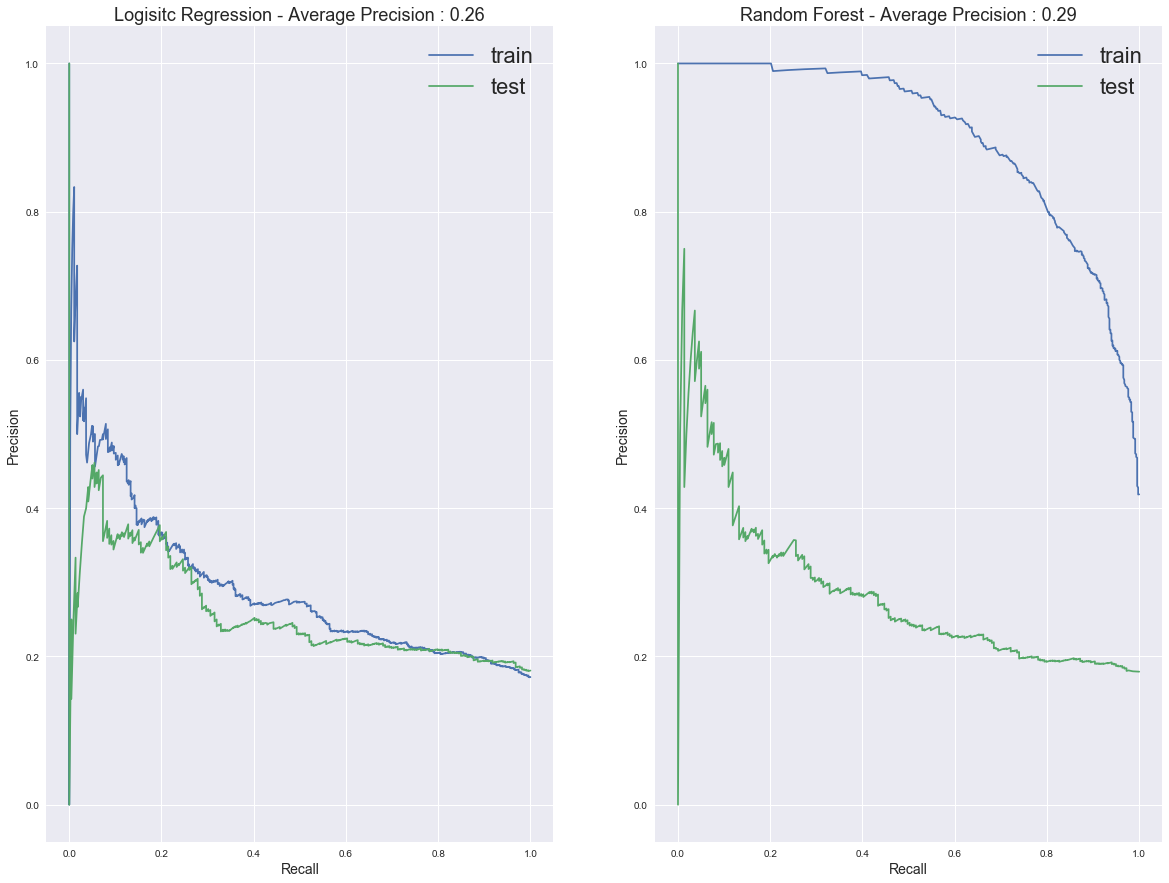

In [287]:
pred_train = logisticReg.predict_proba(X_train)
pred_test = logisticReg.predict_proba(X_test)
pred_train_rf = random_forest.predict_proba(X_train_rf)
pred_test_rf = random_forest.predict_proba(X_test_rf)

print('Logistic Regression Predicted views: {}'.format(np.mean(pred_test[:,1]) * 100))
print('Logistic Regression Calibration Ratio: {}'.format(np.sum(y_test) / np.sum(pred_test[:,1])))
print('Random Forest Predicted views: {}'.format(np.mean(pred_test_rf[:,1]) * 100))
print('Random Forest Calibration Ratio: {}'.format((np.sum(y_test_rf) / np.sum(pred_test_rf[:,1]))))

from sklearn.metrics import precision_recall_curve, average_precision_score

precision_recall_train = precision_recall_curve(y_train, pred_train[:,1])
precision_recall_test = precision_recall_curve(y_test, pred_test[:,1])
precision_recall_train_rf = precision_recall_curve(y_train_rf, pred_train_rf[:,1])
precision_recall_test_rf = precision_recall_curve(y_test_rf, pred_test_rf[:,1])

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.plot(precision_recall_train[1], precision_recall_train[0], label='train')
plt.plot(precision_recall_test[1], precision_recall_test[0], label='test')
plt.legend(fontsize=22)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Logisitc Regression - Average Precision : {0:0.2f}'.format(average_precision_score(y_test, pred_test[:,1])), fontsize=18)
plt.subplot(1,2,2)
plt.plot(precision_recall_train_rf[1], precision_recall_train_rf[0], label='train')
plt.plot(precision_recall_test_rf[1], precision_recall_test_rf[0], label='test')
plt.legend(fontsize=22)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Random Forest - Average Precision : {0:0.2f}'.format(average_precision_score(y_test_rf, pred_test_rf[:,1])), fontsize=18)

# Feature importance

In [281]:
from operator import itemgetter
list(zip(X_train_rf, random_forest.feature_importances_))

[('hour', 0.37220509792373013),
 ('fold', 0.024952939855165782),
 ('screen width', 0.021118830669435928),
 ('ad height', 0.019664330852771604),
 ('load time (ms)', 0.19429424782969582),
 ('avg scroll depth in url', 0.10215945311514185),
 ('browser_chrome', 0.0030616846629605335),
 ('browser_facebook ios', 0.0047403138871747359),
 ('browser_minority', 0.00069496616287168271),
 ('browser_other browser', 0.0017233846019997813),
 ('site_category_28905ebd', 0.013316499569395322),
 ('site_category_3e814130', 0.010455278669155641),
 ('site_category_50e219e0', 0.012899280945095085),
 ('site_category_f028772b', 0.014098523622529328),
 ('site_category_f66779e6', 0.0012918594436250456),
 ('site_category_minority', 0.0028896193696714202),
 ('device_type_desktop', 0.0028874752252698293),
 ('device_type_minority', 0.0012037784153167428),
 ('device_type_mobile', 0.005212783175424833),
 ('device_type_tablet', 0.0034896916933724715),
 ('connection_2G', 0.015254604874329258),
 ('connection_3G', 0.004497

In [288]:
list(zip(X_train.columns[X_train.columns != 'label'], logisticReg.coef_[0]))

[('hour', -0.0050189893049891084),
 ('fold', 0.22445455663815503),
 ('screen width', -0.0018814012442933993),
 ('ad height', 0.0042086201147504268),
 ('load time (ms)', -1.6219942300374958e-05),
 ('avg scroll depth in url', 0.0028762519219870534),
 ('browser_chrome', 0.014947442829702853),
 ('browser_facebook ios', 0.0),
 ('browser_minority', 0.0),
 ('browser_other browser', -0.15185028021530983),
 ('site_category_28905ebd', 0.59610204436929215),
 ('site_category_3e814130', 0.025815110220696522),
 ('site_category_50e219e0', -0.066828590044697336),
 ('site_category_f028772b', 0.0),
 ('site_category_f66779e6', -2.3795311654843716),
 ('site_category_minority', -1.8310191862814313),
 ('device_type_desktop', 0.0),
 ('device_type_minority', -0.18326447762416112),
 ('device_type_mobile', -0.13997434199426773),
 ('device_type_tablet', 0.0068892117586285863),
 ('connection_2G', 0.0),
 ('connection_3G', -0.45884044679994784),
 ('connection_minority', 0.0),
 ('connection_wifi', 0.0609284714458286

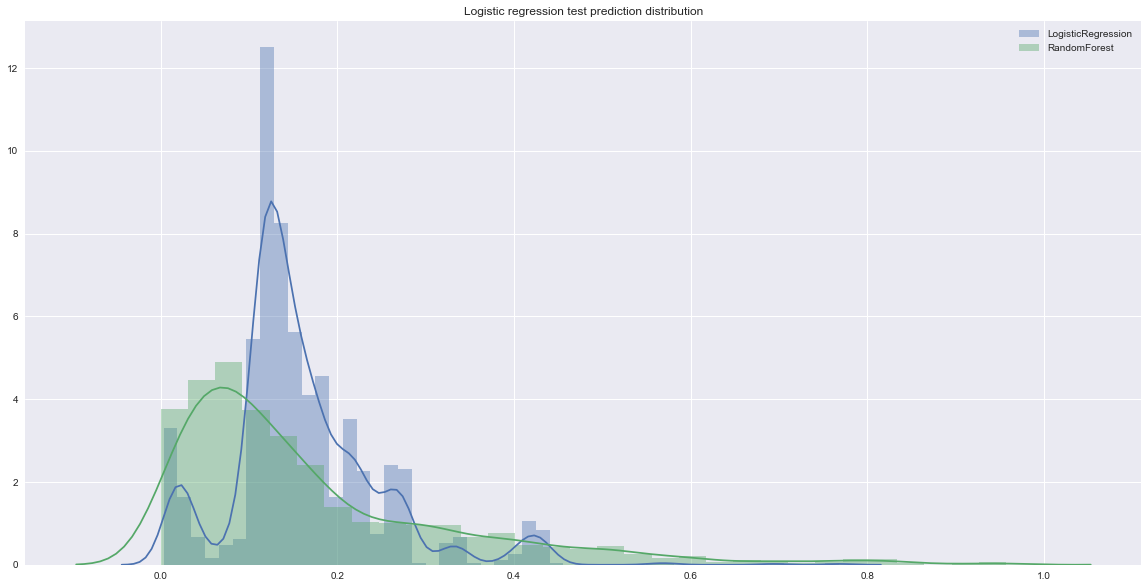

In [289]:
plt.subplots(figsize=(20, 10))
plt.title('Logistic regression test prediction distribution')
sns.distplot(logisticReg.predict_proba(X_test)[:, 1],label = 'LogisticRegression')
sns.distplot(random_forest.predict_proba(X_test_rf)[:, 1],label = 'RandomForest')
plt.legend()

# Conclusions 

Random Forest seems like a better model with those features.
Auc is pretty much the same (~0.61 which is not a good model), but random forest does seem to spread the predictions a bit.

Future work:
 - feature engeneering
 - feature interaction
 - Cross valiation as the data is extremely small.
 - trying XGBoost + SVM as both model converge better.
